In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import os

In [2]:
# Load the dataset (replace 'file_path' with the path to your Excel file)
os.chdir(r'D:\FEPS\4th Year\2nd Semester\Grad Project\STOCK DATA\Codes') # change dir according to user
df = pd.read_excel('EGX30 2010-now.xlsx')

In [3]:
# Parse the date column and set it as index
df['INDEXDATE'] = pd.to_datetime(df['INDEXDATE'])
df.set_index('INDEXDATE', inplace=True)

In [4]:
tf.random.set_seed(123)

In [5]:
# Split the data into training (2016-2021) and test (2022 onwards)
train_data = df.loc['2016-01-01':'2021-12-31']
test_data = df.loc['2022-01-01':]

In [6]:
# Extract the 'INDEXCLOSE' column for training and testing
train_close = train_data[['INDEXCLOSE']]
test_close = test_data[['INDEXCLOSE']]

In [7]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_close)
test_scaled = scaler.transform(test_close)

In [8]:
# Function to create sequences of data
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [9]:
# Define sequence length
seq_length = 30

In [10]:
# Create sequences for training
X_train, y_train = create_sequences(train_scaled, seq_length)

# Create sequences for testing
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape the data to fit the LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [11]:
# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/60
45/45 [==============================] - 6s 43ms/step - loss: 0.0368 - val_loss: 0.0510
Epoch 2/60
45/45 [==============================] - 1s 20ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 3/60
45/45 [==============================] - 1s 21ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 4/60
45/45 [==============================] - 1s 22ms/step - loss: 0.0032 - val_loss: 0.0085
Epoch 5/60
45/45 [==============================] - 1s 27ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 6/60
45/45 [==============================] - 1s 24ms/step - loss: 0.0030 - val_loss: 0.0066
Epoch 7/60
45/45 [==============================] - 1s 22ms/step - loss: 0.0023 - val_loss: 0.0046
Epoch 8/60
45/45 [==============================] - 1s 22ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 9/60
45/45 [==============================] - 1s 21ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 10/60
45/45 [==============================] - 1s 21ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 11/

In [12]:
# Evaluate the model
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

16/16 [==============================] - 1s 6ms/step


In [13]:
# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - y_test_actual)**2))
print(f'RMSE: {rmse}')

# Calculate MAPE
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100
print(f'MAPE: {mape}')

RMSE: 486.97410989711244
MAPE: 2.1291510615731095


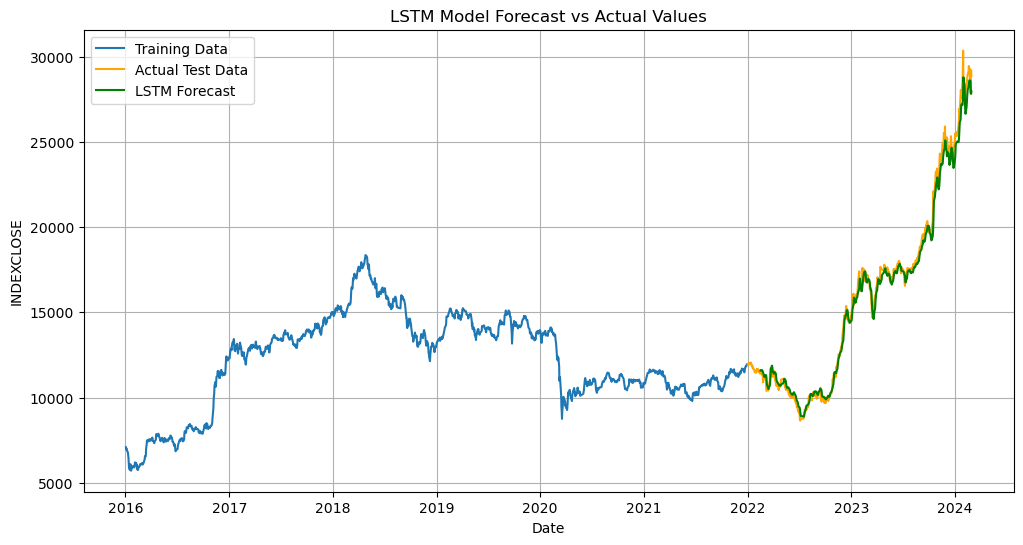

In [14]:
# Plot LSTM forecast vs actual values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['INDEXCLOSE'], label='Training Data')
plt.plot(test_data.index, test_data['INDEXCLOSE'], label='Actual Test Data', color='orange')
plt.plot(test_data.index[seq_length:], predictions, label='LSTM Forecast', color='green')

plt.legend()
plt.xlabel('Date')
plt.ylabel('INDEXCLOSE')
plt.title('LSTM Model Forecast vs Actual Values')
plt.grid(visible=True)
plot_filename = 'LSTM Model Forecast vs Actual Values Uni.png'
plt.savefig(plot_filename)
plt.show()